In [2]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
import statsmodels.tsa.vector_ar.var_model as VAR
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

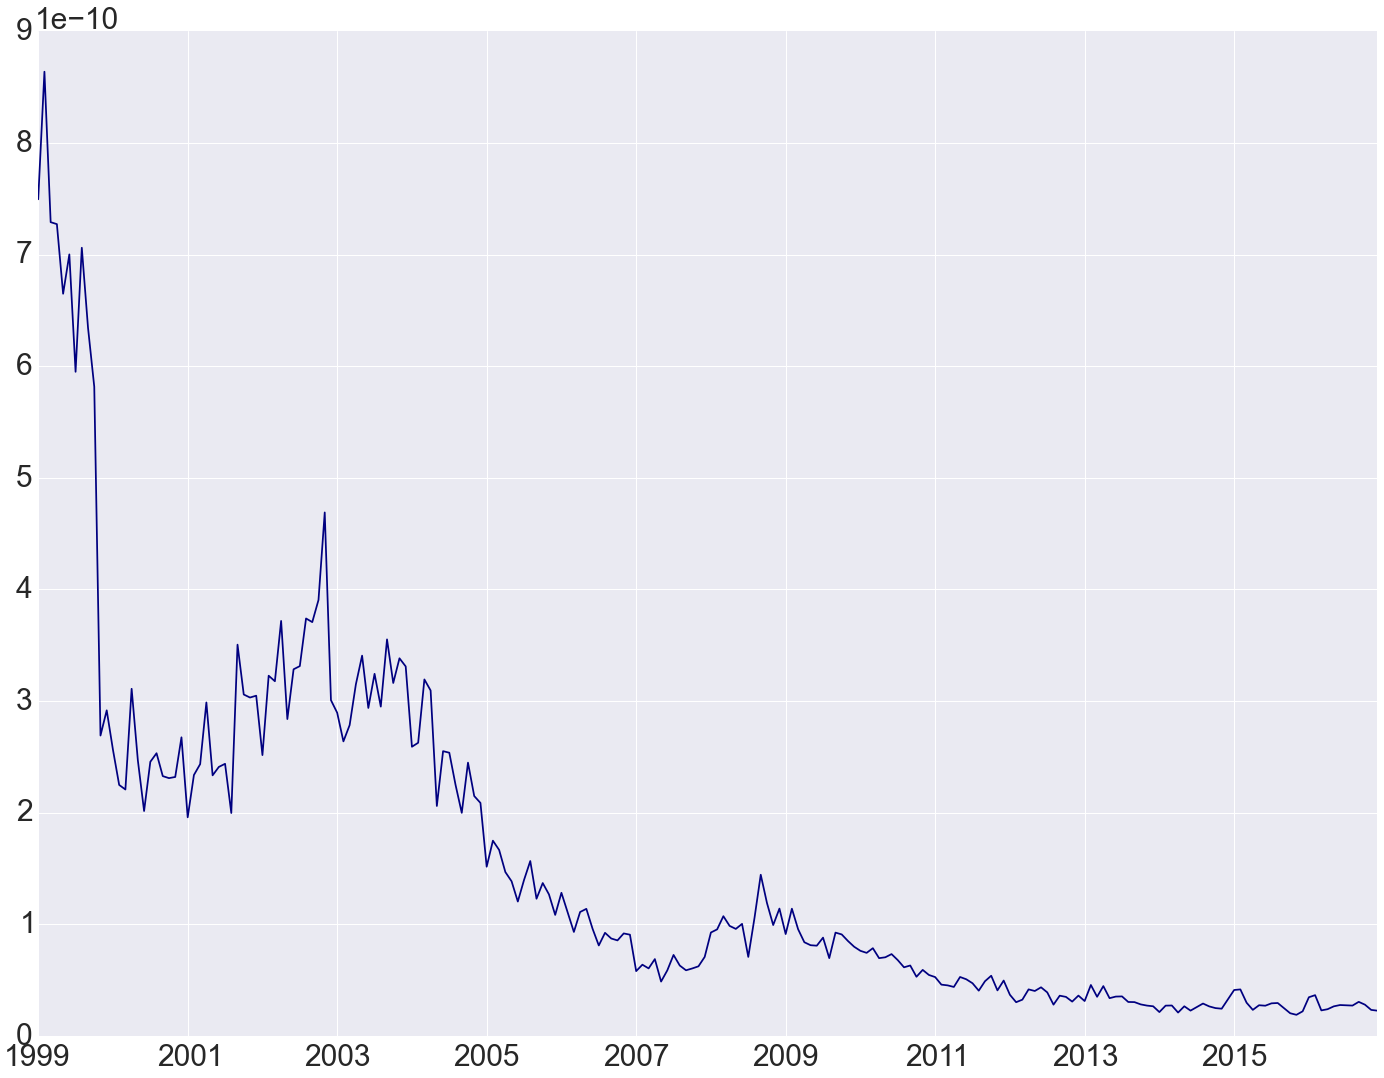

In [5]:
amihud.median(axis=1).dropna().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


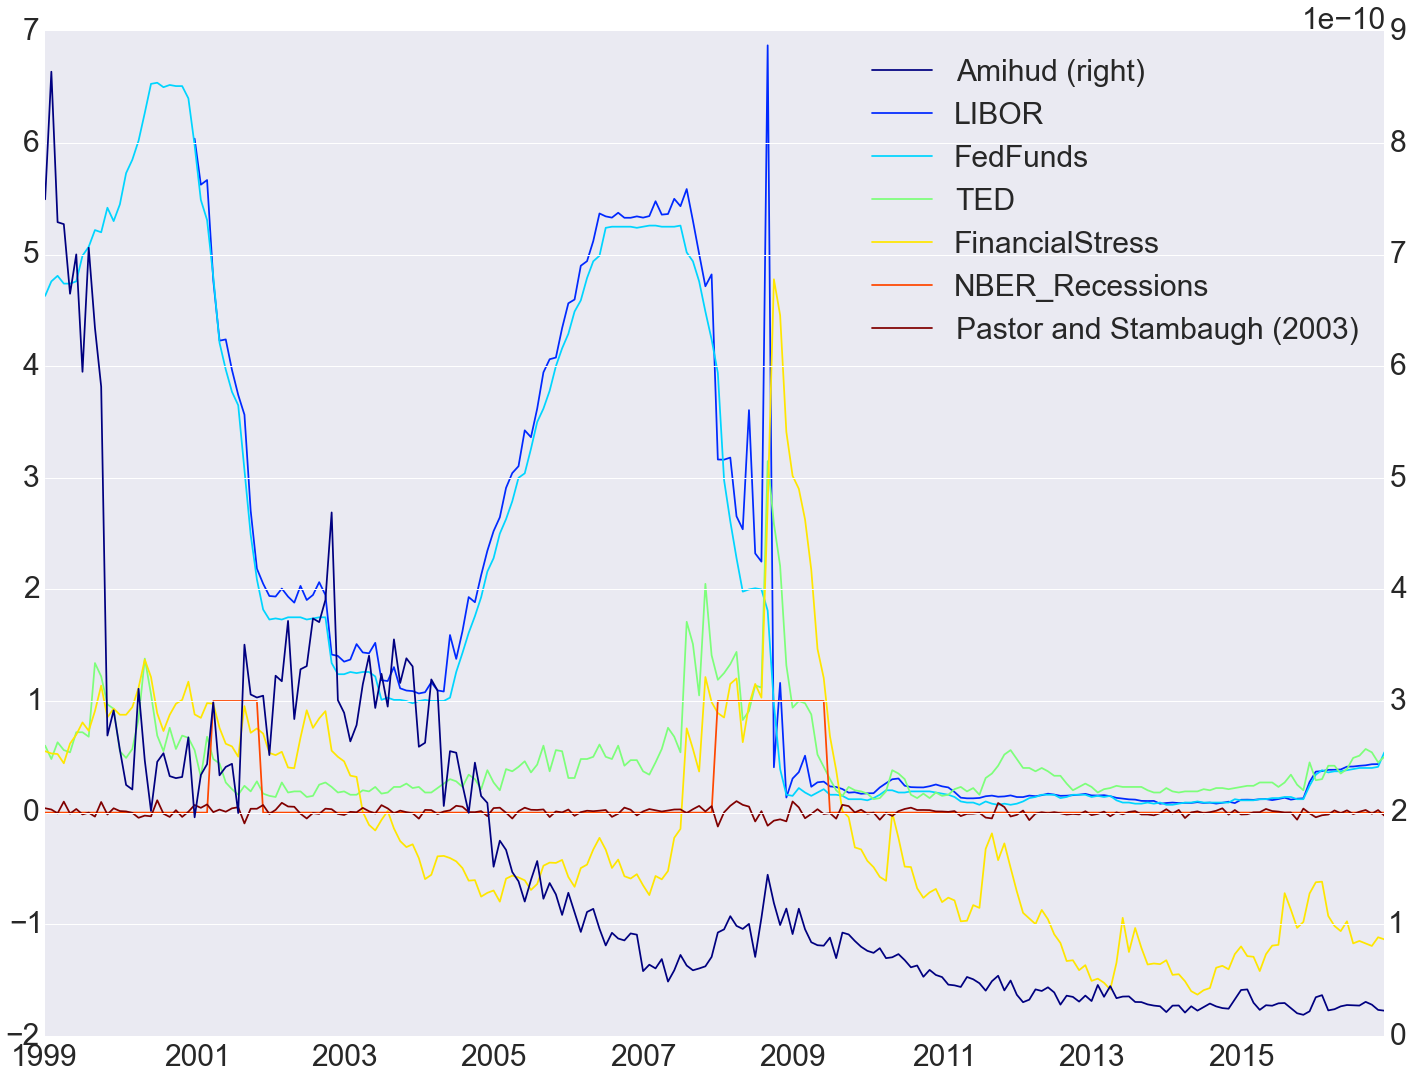

In [8]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
factors.plot(secondary_y='Amihud',colormap='jet')

In [9]:
factors['Amihud']=np.log(amihud.median(axis=1).dropna())

I need to understand what the VAR should look like.  Previously I used something that looked like this:

$$ X_t = \mu + \Phi X_{t-1} - \Sigma \varepsilon_t $$

But what is X in this case?

In [10]:
factors.columns

Index([u'Amihud', u'LIBOR', u'FedFunds', u'TED', u'FinancialStress',
       u'NBER_Recessions', u'Pastor and Stambaugh (2003)'],
      dtype='object')

In [11]:

col=[u'Amihud', u'LIBOR', u'TED', u'FinancialStress',
       u'NBER_Recessions', u'Pastor and Stambaugh (2003)']

In [12]:
res = VAR.VAR(endog=factors[col].dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Aug, 2017
Time:                     13:57:28
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -21.2070
Nobs:                     190.000    HQIC:                  -21.6340
Log likelihood:           507.263    FPE:                3.00801e-10
AIC:                     -21.9248    Det(Omega_mle):     2.42105e-10
--------------------------------------------------------------------
Results for equation Amihud
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -1.299408         0.552088           -2.354           0.020
L1.Amihud                              0.943517         0.024348           38.751        

In [15]:
df=pd.DataFrame()
df['Values']=res.params.Amihud
df['Tstat']=res.tvalues.Amihud

In [16]:
df

,Values,Tstat
const,-1.299408,-2.353626
L1.Amihud,0.943517,38.750531
L1.LIBOR,0.011957,1.337567
L1.TED,-0.077005,-1.361808
L1.FinancialStress,0.044701,1.603239
L1.NBER_Recessions,-0.012055,-0.225777
L1.Pastor and Stambaugh (2003),0.361377,0.997648


In [17]:
x=res.params.Amihud

In [18]:
y=pd.DataFrame()
y['Results']=res.params.Amihud.append(res.tvalues.Amihud)

In [19]:
print y.round(2).to_latex()

\begin{tabular}{lr}
\toprule
{} &  Results \\
\midrule
const                          &    -1.30 \\
L1.Amihud                      &     0.94 \\
L1.LIBOR                       &     0.01 \\
L1.TED                         &    -0.08 \\
L1.FinancialStress             &     0.04 \\
L1.NBER\_Recessions             &    -0.01 \\
L1.Pastor and Stambaugh (2003) &     0.36 \\
const                          &    -2.35 \\
L1.Amihud                      &    38.75 \\
L1.LIBOR                       &     1.34 \\
L1.TED                         &    -1.36 \\
L1.FinancialStress             &     1.60 \\
L1.NBER\_Recessions             &    -0.23 \\
L1.Pastor and Stambaugh (2003) &     1.00 \\
\bottomrule
\end{tabular}



In [20]:
res = VAR.VAR(endog=factors[col].dropna()).fit(2)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Aug, 2017
Time:                     13:57:32
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -21.2416
Nobs:                     189.000    HQIC:                  -22.0374
Log likelihood:           602.680    FPE:                1.56475e-10
AIC:                     -22.5794    Det(Omega_mle):     1.04980e-10
--------------------------------------------------------------------
Results for equation Amihud
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -1.113940         0.573293           -1.943           0.054
L1.Amihud                              0.671736         0.074463            9.021        

In [21]:
res = VAR.VAR(endog=factors[col].dropna()).fit(3)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Aug, 2017
Time:                     13:57:32
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -20.8109
Nobs:                     188.000    HQIC:                  -21.9783
Log likelihood:           654.144    FPE:                1.29244e-10
AIC:                     -22.7735    Det(Omega_mle):     7.25330e-11
--------------------------------------------------------------------
Results for equation Amihud
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.956317         0.584306           -1.637           0.104
L1.Amihud                              0.641430         0.076474            8.388        

In [23]:
model = VAR.VAR(endog=factors[col].dropna())

In [24]:
model.select_order(14)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -12.58       -12.47    3.441e-06       -12.54
1        -22.59       -21.83    1.553e-10       -22.28
2        -23.45      -22.05*    6.554e-11       -22.88
3        -23.67       -21.62    5.303e-11       -22.84
4        -24.13       -21.44    3.350e-11       -23.04
5        -24.32       -20.98    2.800e-11       -22.97
6        -24.33       -20.34    2.831e-11       -22.71
7        -24.25       -19.62    3.127e-11       -22.37
8        -24.61       -19.33    2.253e-11       -22.47
9        -25.00       -19.08    1.578e-11       -22.60
10       -25.58       -19.01    9.296e-12       -22.91
11       -26.04       -18.82    6.244e-12      -23.11*
12      -26.16*       -18.30   5.947e-12*       -22.97
13       -26.07       -17.56    7.162e-12       -22.62
14       -26.05       -16.90    8.121e-12       -22.34
* Minimum


{'aic': 12, 'bic': 2, 'fpe': 12, 'hqic': 11}

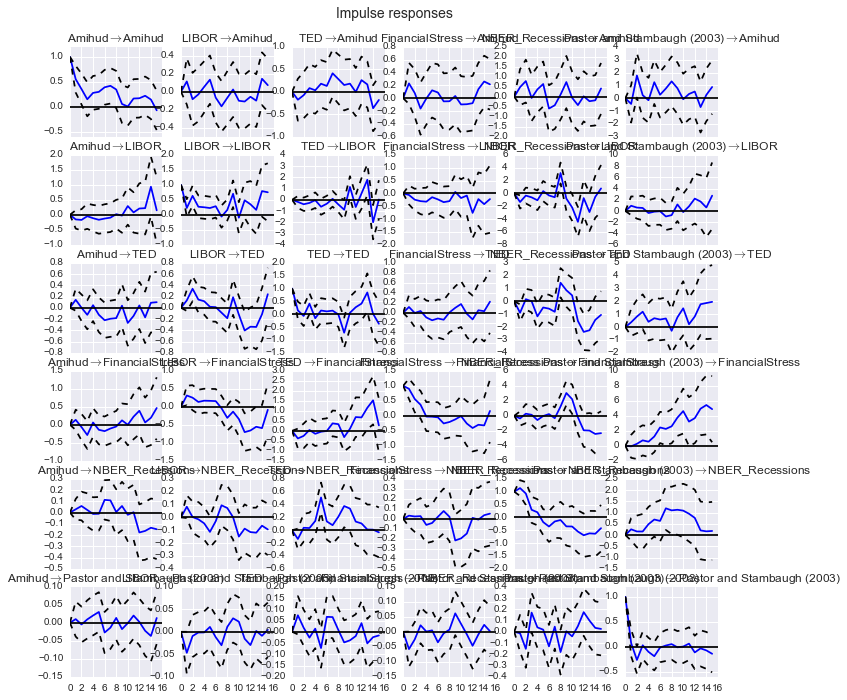

In [41]:
resaic = model.fit(maxlags=20,ic='aic')
irf=resaic.irf(15)
sns.set(font_scale=1)
irf.plot()